In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
train = pd.read_csv("/kaggle/input/titanic/train.csv")
test = pd.read_csv("/kaggle/input/titanic/test.csv")

In [3]:
#Explore data

print(train.head())
print(train.info())
print(train.shape)

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
<c

In [4]:
#Check for missing values
train.isnull().sum()


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
# Handle missing values safely
train['Embarked'] = train['Embarked'].fillna(train['Embarked'].mode()[0])
train['Age'] = train['Age'].fillna(train['Age'].median())

# Drop 'Cabin' only if it exists
train = train.drop(columns=['Cabin'], errors='ignore')

# Confirm no missing values remain
train.isnull().sum()


PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

In [6]:
#Summarize The Data
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.361582,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.019697,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
#Check categorical value
train['Sex'].value_counts()
train['Pclass'].value_counts()
train['Embarked'].value_counts()


Embarked
S    646
C    168
Q     77
Name: count, dtype: int64

In [8]:
#Explore target variable
train['Survived'].value_counts(normalize=True)


Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


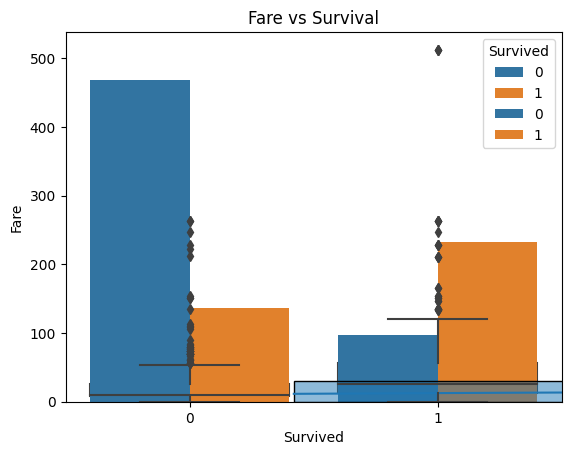

In [9]:
#Explore key relationships
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x="Sex", hue="Survived", data=train)
plt.title("Survival Rate by Gender")

sns.countplot(x="Pclass", hue="Survived", data=train)
plt.title("Survival Rate by Passenger Class")

sns.histplot(train['Age'].dropna(), kde=True)
plt.title("Age Distribution")

sns.boxplot(x="Survived", y="Fare", data=train)
plt.title("Fare vs Survival")
plt.show()


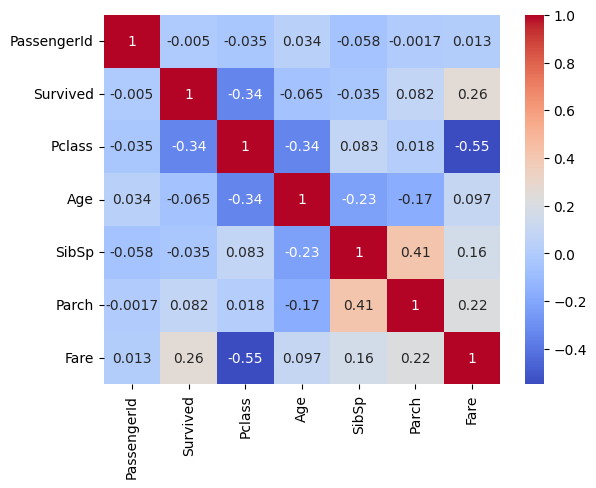

In [10]:
#Check Numeric Correlations
train.corr(numeric_only=True)
sns.heatmap(train.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.show()


In [11]:
#Create new features
train['FamilySize'] = train['SibSp'] + train['Parch']
train['IsAlone'] = (train['FamilySize'] == 0).astype(int)


In [12]:
#Convert Texts to Numbers safely

# 1. Convert 'Sex' to numeric
train['Sex'] = train['Sex'].map({'male': 0, 'female': 1})

# 2. Encode 'Embarked' only if it's still in your columns
if 'Embarked' in train.columns:
    train = pd.get_dummies(train, columns=['Embarked'], drop_first=True)
else:
    print("Embarked already encoded. Found columns:", [c for c in train.columns if c.startswith('Embarked')])


In [13]:
#Do the same for test data
test['Sex'] = test['Sex'].map({'male': 0, 'female': 1})

if 'Embarked' in test.columns:
    test = pd.get_dummies(test, columns=['Embarked'], drop_first=True)
else:
    print("Embarked already encoded in test. Found:", [c for c in test.columns if c.startswith('Embarked')])


In [14]:
#align both datasets
train, test = train.align(test, join='left', axis=1, fill_value=0)


In [15]:
#Verify everything
print(train.columns)
print(test.columns)


Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'FamilySize', 'IsAlone', 'Embarked_Q',
       'Embarked_S'],
      dtype='object')
Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'FamilySize', 'IsAlone', 'Embarked_Q',
       'Embarked_S'],
      dtype='object')


In [16]:
# core
import pandas as pd
import numpy as np

# viz
import seaborn as sns
import matplotlib.pyplot as plt

# ml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# tidy notebook output
pd.set_option("display.max_columns", 100)
sns.set(style="whitegrid", rc={"figure.figsize": (8, 4)})


In [17]:
train = pd.read_csv("/kaggle/input/titanic/train.csv")
test  = pd.read_csv("/kaggle/input/titanic/test.csv")

# quick peek (only the last line auto-renders in notebooks)
train.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [18]:
print("train shape:", train.shape)
print("\ntrain info:")
train.info()
print("\nmissing:\n", train.isnull().sum())


train shape: (891, 12)

train info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

missing:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin  

In [19]:
# Fix missing values

# 1. Embarked → fill with most common value
train["Embarked"] = train["Embarked"].fillna(train["Embarked"].mode()[0])

# 2. Age → fill with median (safer than mean)
train["Age"] = train["Age"].fillna(train["Age"].median())

# 3. Cabin → drop (too many missing)
train = train.drop(columns=["Cabin"], errors="ignore")


In [20]:
train.isnull().sum()


PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

survived rate: 0.384

Sex counts:
 Sex
male      577
female    314
Name: count, dtype: int64

Embarked counts:
 Embarked
S    646
C    168
Q     77
Name: count, dtype: int64


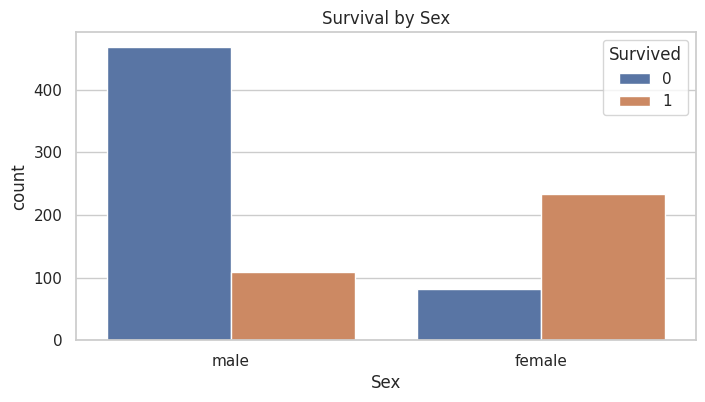

In [21]:
# distribution of target
print("survived rate:", train["Survived"].mean().round(3))

# quick categorical counts
print("\nSex counts:\n", train["Sex"].value_counts(dropna=False))
print("\nEmbarked counts:\n", train["Embarked"].value_counts(dropna=False))

# one fast plot (gender vs survival)
sns.countplot(x="Sex", hue="Survived", data=train); plt.title("Survival by Sex"); plt.show()


In [22]:
# 1) Embarked: fill 2 missings with mode
if train["Embarked"].isna().sum() > 0:
    train["Embarked"] = train["Embarked"].fillna(train["Embarked"].mode()[0])

# 2) Age: fill 177 missings with median
if train["Age"].isna().sum() > 0:
    train["Age"] = train["Age"].fillna(train["Age"].median())

# 3) Cabin: drop (too sparse)
if "Cabin" in train.columns:
    train = train.drop(columns=["Cabin"])


In [23]:
# Embarked
if "Embarked" in test.columns and test["Embarked"].isna().sum() > 0:
    test["Embarked"] = test["Embarked"].fillna(test["Embarked"].mode()[0])

# Age
if test["Age"].isna().sum() > 0:
    test["Age"] = test["Age"].fillna(test["Age"].median())

# Fare (test sometimes has 1 missing)
if "Fare" in test.columns and test["Fare"].isna().sum() > 0:
    test["Fare"] = test["Fare"].fillna(test["Fare"].median())

# Cabin
if "Cabin" in test.columns:
    test = test.drop(columns=["Cabin"])


In [24]:
# family size is predictive on titanic
train["FamilySize"] = train["SibSp"] + train["Parch"]
test["FamilySize"]  = test["SibSp"] + test["Parch"]


In [25]:
# map Sex to 0/1
train["Sex"] = train["Sex"].map({"male": 0, "female": 1})
test["Sex"]  = test["Sex"].map({"male": 0, "female": 1})

# one-hot encode Embarked *if still present*
if "Embarked" in train.columns:
    train = pd.get_dummies(train, columns=["Embarked"], drop_first=True)
if "Embarked" in test.columns:
    test  = pd.get_dummies(test,  columns=["Embarked"], drop_first=True)

# ensure identical columns (fill missing dummies with 0)
train, test = train.align(test, join="left", axis=1, fill_value=0)


In [26]:
# keep only columns you want to model with (drop text/id/target)
cols_to_drop = ["Survived", "Name", "Ticket"]  # target + noisy text-like
X = train.drop(columns=[c for c in cols_to_drop if c in train.columns])

# ensure PassengerId stays as an ID for submission, not as a feature
if "PassengerId" in X.columns:
    X = X.drop(columns=["PassengerId"])

y = train["Survived"]
X.head()


,Pclass,Sex,Age,SibSp,Parch,Fare,FamilySize,Embarked_Q,Embarked_S
0,3,0,22.0,1,0,7.2500,1,False,True
1,1,1,38.0,1,0,71.2833,1,False,False
2,3,1,26.0,0,0,7.9250,0,False,True
3,1,1,35.0,1,0,53.1000,1,False,True
4,3,0,35.0,0,0,8.0500,0,False,True


In [27]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(X_train.shape, X_val.shape)


(712, 9) (179, 9)


In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Train
logreg = LogisticRegression(max_iter=200)
logreg.fit(X_train, y_train)

# Predict on validation set
val_pred = logreg.predict(X_val)

# Evaluate performance
print("Validation accuracy:", round(accuracy_score(y_val, val_pred), 4))
print("\nConfusion matrix:\n", confusion_matrix(y_val, val_pred))
print("\nClassification report:\n", classification_report(y_val, val_pred, digits=3))


Validation accuracy: 0.8045

Confusion matrix:
 [[98 12]
 [23 46]]

Classification report:
               precision    recall  f1-score   support

           0      0.810     0.891     0.848       110
           1      0.793     0.667     0.724        69

    accuracy                          0.804       179
   macro avg      0.802     0.779     0.786       179
weighted avg      0.803     0.804     0.801       179



In [29]:
# Which features still have NaN?
na_counts = X.isnull().sum()
print(na_counts[na_counts > 0].sort_values(ascending=False))


Series([], dtype: int64)


In [30]:
# 1) Restore original Sex from source files using PassengerId as key
raw_train = pd.read_csv("/kaggle/input/titanic/train.csv", usecols=["PassengerId", "Sex"])
raw_test  = pd.read_csv("/kaggle/input/titanic/test.csv",  usecols=["PassengerId", "Sex"])

# drop broken Sex (if present), then merge back the raw column
train = train.drop(columns=["Sex"], errors="ignore").merge(raw_train, on="PassengerId", how="left")
test  = test.drop(columns=["Sex"],  errors="ignore").merge(raw_test,  on="PassengerId", how="left")

# 2) Robust mapping to 0/1
train["Sex"] = train["Sex"].str.strip().str.lower().map({"male": 0, "female": 1})
test["Sex"]  = test["Sex"].str.strip().str.lower().map({"male": 0, "female": 1})

# safety: if anything unmapped slipped through, fill with the mode
if train["Sex"].isna().any():
    train["Sex"] = train["Sex"].fillna(train["Sex"].mode()[0])
if test["Sex"].isna().any():
    test["Sex"] = test["Sex"].fillna(test["Sex"].mode()[0])

# 3) If you encoded Embarked earlier, ensure dummies & alignment remain valid
if "Embarked" in train.columns:
    train = pd.get_dummies(train, columns=["Embarked"], drop_first=True)
if "Embarked" in test.columns:
    test  = pd.get_dummies(test,  columns=["Embarked"], drop_first=True)

train, test = train.align(test, join="left", axis=1, fill_value=0)

# 4) Rebuild X/y and the split
cols_to_drop = ["Survived", "Name", "Ticket"]
X = train.drop(columns=[c for c in cols_to_drop if c in train.columns])
if "PassengerId" in X.columns:
    X = X.drop(columns=["PassengerId"])
y = train["Survived"]

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(X_train.shape, X_val.shape)

# 5) Confirm no NaNs remain in the features you'll train on
na_counts = X_train.isnull().sum()
print("NaNs in X_train:\n", na_counts[na_counts > 0])


(712, 9) (179, 9)
NaNs in X_train:
 Series([], dtype: int64)


In [31]:
X_train.isnull().sum().sum(), X_val.isnull().sum().sum()


(0, 0)

In [32]:
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

imp = SimpleImputer(strategy="median")
X_train_imp = imp.fit_transform(X_train)
X_val_imp   = imp.transform(X_val)

logreg = LogisticRegression(max_iter=200)
logreg.fit(X_train_imp, y_train)

val_pred = logreg.predict(X_val_imp)
print("Validation accuracy:", round(accuracy_score(y_val, val_pred), 4))
print("\nConfusion matrix:\n", confusion_matrix(y_val, val_pred))
print("\nClassification report:\n", classification_report(y_val, val_pred, digits=3))


Validation accuracy: 0.8045

Confusion matrix:
 [[98 12]
 [23 46]]

Classification report:
               precision    recall  f1-score   support

           0      0.810     0.891     0.848       110
           1      0.793     0.667     0.724        69

    accuracy                          0.804       179
   macro avg      0.802     0.779     0.786       179
weighted avg      0.803     0.804     0.801       179



In [33]:
# re-use the same SimpleImputer + LogisticRegression pattern

from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

# fit imputer on full train features (X), then transform both X and test
imp_full = SimpleImputer(strategy="median")
X_full_imp = imp_full.fit_transform(X)
X_test_imp = imp_full.transform(test[X.columns])  # columns aligned earlier

# fit model on full training data, then predict test
logreg = LogisticRegression(max_iter=200)
logreg.fit(X_full_imp, y)
test_pred = logreg.predict(X_test_imp)


In [34]:
submission = pd.DataFrame({
    "PassengerId": test["PassengerId"].astype(int),
    "Survived": test_pred.astype(int)
})
submission.to_csv("submission.csv", index=False)
submission.head()


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


---

### 📂 Project Links

- 💻 [GitHub Repository](https://github.com/treasure-nweze/titanic-survival-analysis)
- 🏆 [Kaggle Competition Page](https://www.kaggle.com/c/titanic)
- 📈 [My Kaggle Submission (Score: 0.76555)](https://www.kaggle.com/code/your-kaggle-username/titanic-v1-baseline)
